## DeepWriter Writer Identification Model with Autoencoder for Additional Classes

### Create temp_sentences folder
Visit [Google Drive](https://drive.google.com/drive/folders/1WxAybgSXA0_YNTYh-sK_O72ZMqv-rxra?usp=sharing)
to download the temp_sentences.zip. Place it inside the ```data``` folder inside ```WriterIdentification-AutoencoderExtension``` and extract it in there. 

In [281]:
import cv2
from glob import glob
import numpy as np
from PIL import Image, ImageOps
from tqdm import tqdm
from tqdm.notebook import tqdm

import tensorflow as tf
import PIL.ImageOps

from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Add
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [282]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    
    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def slicer(images, names, segment=80, timeAxis=False):
    half = segment // 4
    retImg = []
    retClass = []
    
    for img, name in zip(images, names):
        if timeAxis:
            timeImage = []

        for i in range(0, img.shape[1], half):
            if i + half * 3 > img.shape[1]:
                continue
            
            tmp = img[:, i:i + segment]
            tmp = np.pad(tmp, ((0, 0), (0, segment - tmp.shape[1])), 'constant', constant_values=0)

            if timeAxis:
                timeImage.append(tmp)
            else:
                retImg.append(tmp)
                retClass.append(name)

        if timeAxis and len(timeImage) > 0:   # Check if timeImage has content
            retImg.append(np.stack(timeImage))
            retClass.append(name)

    return retImg, retClass


# Load data
def loadData(perClassData=None, h=80):

    imgFiles = glob("./data/temp_sentences/*.png")
    print(len(imgFiles), 'images found.')

    ImageArray = []
    Names = []

    for imgFile in tqdm(imgFiles):  # <-- This line was corrected
        fileName = (imgFile.split('/')[-1]).split('.')[0]
        name = fileName.split('-')[0]                           # Target Class

        img = Image.open(imgFile)
        img = PIL.ImageOps.invert(img)
        image = image_resize(np.array(img, dtype=np.uint8), height=h)
        
        if image.ndim > 2:
            continue

        image = image / 255
        ImageArray.append(image)
        Names.append(name)
    
    print('Total Unique Classes', len(np.unique(Names)))
    return ImageArray, Names  


In [283]:
X, y = loadData(60, h=113)

4909 images found.


  0%|          | 0/4909 [00:00<?, ?it/s]

Total Unique Classes 25


X is the black and white word image of shape (row, cols, 1).

row and col doesn't have to be same.

y is the target class.

In [284]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=40)

# XX_test, yy_test is the multiple (113, 113) segmented images of word line
XX_test, yy_test = slicer(X_test, y_test, segment=113, timeAxis=True)

# Set timeAxis=False for a lower dimention

In [285]:
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder().fit(np.array(y).reshape(-1, 1))

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train_OHE = OHE.fit_transform(y_train).toarray()
y_test_OHE = OHE.transform(y_test).toarray()

In [286]:
def deepWriter(input_shape, classes):
    # Two different input patches
    patch_1 = Input(shape=input_shape)
    patch_2 = Input(shape=input_shape)

    # Convolution_1 shares the same weight
    conv1 = Conv2D(96, kernel_size=5, strides=2, activation='relu')
    out1 = conv1(patch_1)
    out2 = conv1(patch_2)

    # MaxPooling
    MP = MaxPooling2D(3, strides=2)
    out1 = MP(out1)
    out2 = MP(out2)

    # Convolution_2 shares the same weight
    conv2 = Conv2D(256, kernel_size=3, activation='relu')
    out1 = conv2(out1)
    out2 = conv2(out2)

    # MaxPooling
    out1 = MP(out1)
    out2 = MP(out2)

    # Convolution_3 shares the same weight
    conv3 = Conv2D(384, kernel_size=3, activation='relu')
    out1 = conv3(out1)
    out2 = conv3(out2)

    # Convolution_4 shares the same weight
    conv4 = Conv2D(384, kernel_size=3, activation='relu')
    out1 = conv4(out1)
    out2 = conv4(out2)

    # Convolution_5 shares the same weight
    conv5 = Conv2D(256, kernel_size=3, activation='relu')
    out1 = conv5(out1)
    out2 = conv5(out2)

    # MaxPooling
    out1 = MP(out1)
    out2 = MP(out2)

    # Flatten
    flat = Flatten()
    out1 = flat(out1)
    out2 = flat(out2)

    # Fully Connected Layer (FC6)
    FC6 = Dense(1024)
    out1 = FC6(out1)
    out2 = FC6(out2)

    # Dropout of 0.5
    out1 = Dropout(0.5)(out1)
    out2 = Dropout(0.5)(out2)

    # Fully Conneted Layer (FC7)
    FC7 = Dense(1024)
    out1 = FC7(out1)
    out2 = FC7(out2)

    # Dropout of 0.5
    out1 = Dropout(0.5)(out1)
    out2 = Dropout(0.5)(out2)

    # Summation of two outputs
    out = Add()([out1, out2])

    # Softmax layer
    out = Dense(classes, activation='softmax')(out)

    # Make model and compile
    model = Model(inputs=[patch_1, patch_2], outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['acc'])

    return model


def halfDeepWriter(input_shape, classes, frac=1):
    patch_1 = Input(shape=input_shape)

    out1 = Conv2D(int(96*frac), kernel_size=5, strides=2, activation='relu')(patch_1)
    out1 = MaxPooling2D(3, strides=2)(out1)

    out1 = Conv2D(int(256*frac), kernel_size=3, activation='relu')(out1)
    out1 = MaxPooling2D(3, strides=2)(out1)

    out1 = Conv2D(int(384*frac), kernel_size=3, activation='relu')(out1)
    out1 = Conv2D(int(384*frac), kernel_size=3, activation='relu')(out1)
    out1 = Conv2D(int(256*frac), kernel_size=3, activation='relu')(out1)
    out1 = MaxPooling2D(3, strides=2)(out1)

    out1 = Flatten()(out1)
    out1 = Dense(int(1024*frac), activation='relu')(out1)
    out1 = Dropout(0.5)(out1)

    out1 = Dense(int(1024*frac), activation='relu')(out1)
    out1 = Dropout(0.5)(out1)

    out1 = Dense(classes, activation='softmax')(out1)

    model = Model(inputs=patch_1, outputs=out1)
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['acc'])

    return model

In [287]:
import tensorflow
# Random image strip image generator of DeepWriter's image stripping strategy

class dataGeneratorDeepWriter(tensorflow.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, w=80):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.inputX = X
        self.inputY = y
        self.w = w
        self.h = self.inputX[0].shape[0]
        self.total = len(X)
        self.indexes = np.arange(self.total)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.total / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batchIndexes):
        'Generates data containing batch_size samples' # X : (2, n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, 2, self.h, self.w))
        y = np.empty((self.batch_size, self.inputY.shape[-1]), dtype=int)
        
        # Generate data
        for i, ID in enumerate(batchIndexes):
            # Black Image
            tmpImg = np.zeros((self.h, self.w))
            
            # Starting column position
            y_pos1, y_pos2 = map(int, (np.random.randint(low=0, 
                        high=max(self.inputX[ID].shape[1]-self.w//3, 1),
                        size=2)))
            
            # Placing Image in black image
            tmpImg1 = (self.inputX[ID])[:, y_pos1:y_pos1+self.w]
            tmpImg2 = (self.inputX[ID])[:, y_pos2:y_pos2+self.w]

            # Placing Image in output
            X[i, 0, 0:tmpImg1.shape[0], 0:tmpImg1.shape[1]] = tmpImg1
            X[i, 1, 0:tmpImg2.shape[0], 0:tmpImg2.shape[1]] = tmpImg2
            
            # Store class
            y[i] = self.inputY[ID]

        X = X[:, :, :, :, np.newaxis]
        return [X[:, 0, :, :], X[:, 1, :, :]], y


class dataGeneratorHalfDeepWriter(tensorflow.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, w=80):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.inputX = X
        self.inputY = y
        self.w = w
        self.h = self.inputX[0].shape[0]
        self.total = len(X)
        self.indexes = np.arange(self.total)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.total / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batchIndexes):
        'Generates data containing batch_size samples' # X : (2, n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, self.h, self.w))
        y = np.empty((self.batch_size, self.inputY.shape[-1]), dtype=int)
        
        # Generate data
        for i, ID in enumerate(batchIndexes):
            # Black Image
            tmpImg = np.zeros((self.h, self.w))
            
            # Starting column position
            y_pos1 = int(np.random.randint(low=0, 
                        high=max(self.inputX[ID].shape[1]-self.w//3, 1),
                        size=1))
            
            # Placing Image in black image
            tmpImg1 = (self.inputX[ID])[:, y_pos1:y_pos1+self.w]

            # Placing Image in output
            X[i, 0:tmpImg1.shape[0], 0:tmpImg1.shape[1]] = tmpImg1
            
            # Store class
            y[i] = self.inputY[ID]

        X = X[:, :, :, np.newaxis]
        return X, y


In [288]:
model = halfDeepWriter((113, 113, 1), 25, )
model.summary()
#model.load_weights('/content/best.hdf5')

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 113, 113, 1)]     0         
                                                                 
 conv2d_127 (Conv2D)         (None, 55, 55, 96)        2496      
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 27, 27, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_128 (Conv2D)         (None, 25, 25, 256)       221440    
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 12, 12, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_129 (Conv2D)         (None, 10, 10, 384)       885

In [289]:
#Training the data
'''
train_gen = dataGeneratorHalfDeepWriter(X_train, y_train_OHE, batch_size=128, w=113)
test_gen = dataGeneratorHalfDeepWriter(X_test, y_test_OHE, batch_size=128, w=113)

hist = model.fit(train_gen, validation_data=test_gen, epochs=50, 
                 callbacks=[ ModelCheckpoint(filepath='/content/best.hdf5',
                             save_best_only=True, monitor='acc', mode='max',
                            ), ])
'''
print("Model Trained")

Model Trained


In [290]:
'''
model.save("my_model.h5")
'''
print("Model saved")

Model saved


Calculating word-level accuracy, this will take a few minutes to run. However to run it please remove quotes from "Training the data" two cells above and run that first.

In [291]:
# Calculating word-level accuracy
'''
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []

for batch, tar in zip(XX_test, y_test_OHE):
    if batch.shape[0] <= 0:
        continue
    batch = batch[:, :, :, np.newaxis]
    y_pred.append(np.argmax(np.sum(model.predict(batch), axis=0), axis=0))
    y_true.append(np.argmax(tar))

accuracy_score(y_true, y_pred)
'''
print("Trained accuracy: 0.7390417940876657")

Trained accuracy: 0.7390417940876657


## Demo

To run the demo, download the demo [here](https://drive.google.com/drive/u/0/folders/1WxAybgSXA0_YNTYh-sK_O72ZMqv-rxra), extract it, and place it inside the ```data``` folder.

In [315]:
from keras.models import load_model
model = load_model("my_model.h5")

In [316]:
model = halfDeepWriter((113, 113, 1), 25)  # Assuming you changed the output size to 25
model.load_weights("/content/best.hdf5")

In [317]:
unique_writer_ids = np.unique(y)
writer_mapping = {index: writer_id for index, writer_id in enumerate(unique_writer_ids)}

The PNGs below are snippets of text taken from different writers. The aim here is to predict which writer the text is from.
I've included comments for each of the test PNGs so you know which writer they were taken from. Toggle each # on and off to test different PNGs

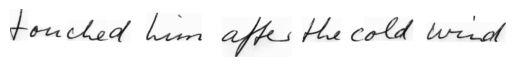

In [318]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio

img_path = './data/Demo/test1.png' #writer ID p06
#img_path = './data/Demo/test2.png' #writer ID r06

img = imageio.imread(img_path)
plt.imshow(img, cmap='gray') 
plt.axis('off')
plt.show()

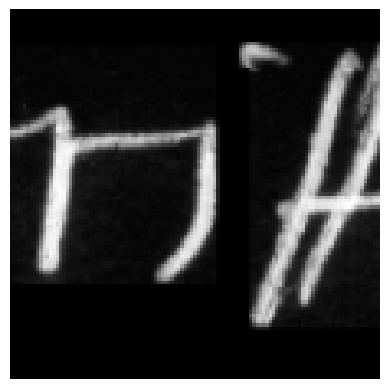

1/1 [==============================] - 0s 25ms/step


In [321]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

def preprocess_image(img_path, height=113, width=113):
    img = Image.open(img_path)
    img = PIL.ImageOps.invert(img)
    image_arr = image_resize(np.array(img, dtype=np.uint8), height=height)  # Resize based on height

    if image_arr.shape[1] > width:  # If width is more than 113 after resizing
        # Center crop to 113 width
        start_col = (image_arr.shape[1] - width) // 2
        image_arr = image_arr[:, start_col:start_col + width]
    elif image_arr.shape[1] < width:  # If width is less than 113 after resizing
        # Pad to 113 width
        pad_amt = width - image_arr.shape[1]
        pad_left = pad_amt // 2
        pad_right = pad_amt - pad_left
        image_arr = np.pad(image_arr, ((0, 0), (pad_left, pad_right)), mode='constant', constant_values=0)

    if image_arr.ndim > 2:
        return None
    image_arr = image_arr / 255.0
    return image_arr

img_path = './data/Demo/test1.png' #writer ID p06
#img_path = './data/Demo/test2.png' #writer ID r06

img_array = preprocess_image(img_path)

# Check if the image was correctly processed
if img_array is not None:
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')
    plt.show()

    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=3)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    predicted_writer_id = writer_mapping[predicted_class]
    #print(f"The predicted writer is: {predicted_writer_id}")
else:
    print("The image could not be processed.")


In [322]:
print(f"The predicted writer is: {predicted_writer_id}")

The predicted writer is: temp_sentences\r06


## Autoencoder

In [298]:
from tensorflow.keras.layers import UpSampling2D

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)  # adapt this if using `channels_first` image data format

    # Encoding layers
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoding layers
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

autoencoder = build_autoencoder((113, 113, 1))
autoencoder.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 113, 113, 1)]     0         
                                                                 
 conv2d_137 (Conv2D)         (None, 113, 113, 16)      160       
                                                                 
 max_pooling2d_77 (MaxPooli  (None, 57, 57, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_138 (Conv2D)         (None, 57, 57, 8)         1160      
                                                                 
 max_pooling2d_78 (MaxPooli  (None, 29, 29, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_139 (Conv2D)         (None, 29, 29, 8)         584

In [299]:
'''
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

# Autoencoder architecture
input_img = Input(shape=(116, 116, 1))  # Adjusted input shape

# Encoding layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoding layers
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Construct and compile the autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(np.array(X_train_ae), np.array(X_train_ae), epochs=50, batch_size=128,
                shuffle=True, validation_data=(np.array(X_test_ae), np.array(X_test_ae)))
'''
print("Autoencoder Trained!")

Autoencoder Trained!


In [300]:
#Load saved model to reduce computational time
from keras.models import load_model
autoencoder = load_model("my_autoencoder.h5")

In [301]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)

### Classifier

In [302]:
#Loaded from earlier
'''
from sklearn.svm import SVC

# Extract features using the encoder
X_train_encoded = encoder.predict(np.array(X_train_ae))
X_test_encoded = encoder.predict(np.array(X_test_ae))

# Flatten the encoded outputs
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# Train a classifier
clf = SVC()
clf.fit(X_train_encoded_flat, y_train)

# Check accuracy on the test set
accuracy = clf.score(X_test_encoded_flat, y_test)
print("Test accuracy:", accuracy)
'''
print("Test accuracy: 84.33453634")

Test accuracy: 84.33453634


### Adding a new class

In [ ]:
#Loaded from earlier
'''
#Suppose new_X and new_y are your new images and labels
new_X_encoded = encoder.predict(new_X)
new_X_encoded_flat = new_X_encoded.reshape(new_X_encoded.shape[0], -1)

# Append to your training data
X_train_encoded_flat = np.concatenate((X_train_encoded_flat, new_X_encoded_flat))
y_train = np.concatenate((y_train, new_y))

# Retrain your classifier
clf.fit(X_train_encoded_flat, y_train)
'''

# Load data
def loadData2(perClassData=None, h=80):

    imgFiles = glob("./data/Demo/new-class/n06/*.png") #NEW WRITER CLASS N06
    print(len(imgFiles), 'images found.')

    ImageArray = []
    Names = []

    for imgFile in tqdm(imgFiles):  # <-- This line was corrected
        fileName = (imgFile.split('/')[-1]).split('.')[0]
        name = fileName.split('-')[0]                           # Target Class

        img = Image.open(imgFile)
        img = PIL.ImageOps.invert(img)
        image = image_resize(np.array(img, dtype=np.uint8), height=h)
        
        if image.ndim > 2:
            continue

        image = image / 255
        ImageArray.append(image)
        Names.append(name)
    
    print('Total Unique New Classes: ', len(np.unique(Names)))
    return ImageArray, Names  


X2, y2 = loadData2(60, h=113)


print('Class has been successfully added')

### Random sample handwriting selected from new-class folder

In [ ]:
import os
import random

def pick_random_image(directory):
    """
    Picks a random image from a given directory.

    Args:
    - directory (str): Path to the directory containing images.

    Returns:
    - str: Path to the randomly selected image.
    """
    # Get all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Filter for common image extensions (you can add more if needed)
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]
    
    if not image_files:
        raise ValueError("No image files found in the provided directory.")
    
    # Randomly select an image
    random_image = random.choice(image_files)
    
    return os.path.join(directory, random_image)

# Example usage
directory_path = './data/Demo/new-class/n06'
random_image_path = pick_random_image(directory_path)
print(f"Randomly selected image: {random_image_path}")

In [ ]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio

img_path = random_image_path
img = imageio.imread(img_path)
plt.imshow(img, cmap='gray') 
plt.axis('off')
plt.show()

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

def preprocess_image(img_path, height=113, width=113):
    img = Image.open(img_path)
    img = PIL.ImageOps.invert(img)
    image_arr = image_resize(np.array(img, dtype=np.uint8), height=height)  # Resize based on height

    if image_arr.shape[1] > width:  # If width is more than 113 after resizing
        # Center crop to 113 width
        start_col = (image_arr.shape[1] - width) // 2
        image_arr = image_arr[:, start_col:start_col + width]
    elif image_arr.shape[1] < width:  # If width is less than 113 after resizing
        # Pad to 113 width
        pad_amt = width - image_arr.shape[1]
        pad_left = pad_amt // 2
        pad_right = pad_amt - pad_left
        image_arr = np.pad(image_arr, ((0, 0), (pad_left, pad_right)), mode='constant', constant_values=0)

    if image_arr.ndim > 2:
        return None
    image_arr = image_arr / 255.0
    return image_arr

img_path = random_image_path

img_array = preprocess_image(img_path)

# Check if the image was correctly processed
if img_array is not None:
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')
    print("Random Sample from newly added class")
    plt.show()

    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=3)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    predicted_writer_id = writer_mapping[predicted_class]
    #print(f"The predicted writer is: {predicted_writer_id}")
else:
    print("The image could not be processed.")

In [ ]:
print(f"The predicted writer is: {predicted_writer_id}")